# Hierarchical Network Embedding for Community Detection

## Imports

In [47]:
import numpy as np

import torch, torch.nn as nn, torch.autograd as autograd
import torch.utils.data
from torch.distributions import multivariate_normal
# from scipy.stats import multivariate_normal

from dgl import DGLGraph
from dgl.data import citation_graph as citegrh

import networkx as nx

import matplotlib.pyplot as plt

## Constants

In [48]:
K = 7

## Utility functions

In [62]:
def vectorize(row):
    return np.array(row.split(" ")).astype(float)

def skipgram2dict(skipgram):
    d = dict(skipgram[i].split(" ", 1) for i in range(len(skipgram)))
    d = {int(num): vectorize(v) for num, v in d.items()}
    
    return d

In [38]:
#!deepwalk --help

#!deepwalk --input ../graphsage/cora/cora.adjlist --representation-size 400 --walk-length 40 --output ../graphsage/cora/cora.embeddings

## Data preparation

In [63]:
with open("../graphsage/cora/cora.embeddings", "r") as f:
    skipgram = f.readlines()
    
print("Number of nodes: {} in {}-dimensional representation".format(*skipgram.pop(0).split()))
    
dataset = skipgram2dict(skipgram)

Number of nodes: 2708 in 400-dimensional representation


In [134]:
model = nn.Sequential(
    nn.Linear(400, 1024),
    nn.Dropout(0.05),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.Dropout(0.05),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.05),
    nn.ReLU(),
    nn.Linear(256, 400),
    nn.Softmax()
)

In [135]:
batch_size = 100
train_batch_gen  = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

## [ComE](https://sentic.net/community-embedding.pdf) algorithm

In [136]:
eps  = 1e-6
beta = 1e-4

def compute_loss(model, X_batch, pi, psi, Sigma):
    X_batch = model(X_batch)
    # Probabilities (X_batch, K)
    log_probs         = compute_probs(X_batch, psi, Sigma)
    probs             = log_probs.exp()
    # Gamma (X_batch, K)
    gamma             = compute_gamma(pi, probs)
    # N (1, K)
    N                 = gamma.sum(dim=0, keepdim=True)
    # Pi (1, K)
    pi                = N / X_batch.size(0)
    # Psi (mean)
    psi               = []
    # Sigma (covariance)
    Sigma             = []
    
    for k in range(K):
        psi_k   = compute_mean_k(N[:, k], gamma[:, k], X_batch)
        Sigma_k = compute_cov_k(N[:, k], gamma[:, k], X_batch, psi_k)
        
        psi.append(psi_k.view(X_batch.size()[1]))
        Sigma.append(torch.diagflat(Sigma_k))
    
    loss = -(beta / K) * torch.sum(torch.sum(pi * log_probs, dim=1, keepdim=True))
    print(loss)
    
    return pi, psi, Sigma, loss

def compute_probs(X_batch, psi, Sigma):
    probs = torch.FloatTensor()
    
    for psi_k, Sigma_k in list(zip(psi, Sigma)):
        normal_k = multivariate_normal.MultivariateNormal(psi_k, Sigma_k)
        # Probability (X_batch, 1)
        prob_k   = normal_k.log_prob(X_batch).view(X_batch.size()[0], 1)
        prob_k   = torch.clamp(prob_k, max=0.)
        probs    = torch.cat((probs, prob_k), dim=1)
        
    return probs

def compute_gamma(pi, probs):
    gamma_numerator   = pi * probs + eps
    gamma_denominator = torch.sum(gamma_numerator, dim=1, keepdim=True)
    
    return torch.div(gamma_numerator, gamma_denominator)
    
def compute_mean_k(N_k, gamma_k, X_batch):
    return (1 / N_k) * torch.sum(gamma_k.view(-1, 1) * X_batch, dim=0, keepdim=True)

def compute_cov_k(N_k, gamma_k, X_batch, psi_k):
    return (1 / N_k) * torch.sum(gamma_k.view(-1, 1) * (X_batch - psi_k) * (X_batch - psi_k), dim=0, keepdim=True) + eps

def set_pi(X_batch):
    row_count = X_batch.size(0)
    
    return torch.ones(row_count, K) / K

def reset_mean(X_batch):
    data    = X_batch.numpy()
    psi_k   = np.mean(data, axis=0)
    psi_k   = torch.tensor(psi_k, dtype=torch.float, requires_grad=True)
    
    return psi_k

def reset_cov(X_batch):
    data    = X_batch.numpy()
    Sigma_k = np.cov(data, rowvar=False)
    # Ensure that the covariance matrix is positive semi-definite
    Sigma_k = np.add(Sigma_k, np.eye(400) * eps)
    Sigma_k = torch.tensor(Sigma_k, dtype=torch.float, requires_grad=True)
    
    return Sigma_k

In [137]:
torch.manual_seed(1234)

pi    = None
psi   = []
Sigma = []

num_epochs = 1
train_loss = []

opt = torch.optim.SGD(model.parameters(), lr=0.025, momentum=0.5)

train_batch_gen_iter = iter(train_batch_gen)

for i in range(K):
    X_batch = next(train_batch_gen_iter)
    psi_k   = reset_mean(X_batch.float())
    Sigma_k = reset_cov(X_batch.float())
    
    psi.append(psi_k)
    Sigma.append(Sigma_k)

for epoch in range(num_epochs):
    model.train(True)
    
    print("Epoch: {}".format(epoch))
    
    for X_batch in train_batch_gen:
        if pi is None:
            pi = set_pi(X_batch.float())
        
        with autograd.detect_anomaly():
            # Update mean, cov
            pi, psi, Sigma, loss = compute_loss(model, X_batch.float(), pi, psi, Sigma)
            loss.backward(retain_graph=True)
            
            opt.step()
            opt.zero_grad()
            
        train_loss.append(loss.data.cpu().numpy())
        
    print("Training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(dataset) // train_batch_size :]))
    )

model.train(False)

Epoch: 0
tensor(1072.7465, grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., grad_fn=<MulBackward0>)
tensor(-0., g

Sequential(
  (0): Linear(in_features=400, out_features=1024, bias=True)
  (1): Dropout(p=0.05)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): Dropout(p=0.05)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): Dropout(p=0.05)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=400, bias=True)
  (10): Softmax()
)

## Expirements

In [138]:
result = []

e = list(dataset.values())
x = model(torch.tensor(e).float())

log_probs       = compute_probs(x, psi, Sigma)
values, indices = (pi * log_probs.exp()).max(1)
result          = np.append(result, indices)

In [139]:
print(np.sum(result==0),
      np.sum(result==1),
      np.sum(result==2),
      np.sum(result==3),
      np.sum(result==4),
      np.sum(result==5),
      np.sum(result==6))

0 0 0 0 0 0 2708


In [102]:
data = citegrh.load_cora()
G = DGLGraph(data.graph)
kn = G.to_networkx()

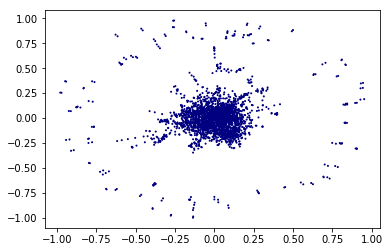

In [103]:
pos = nx.spring_layout(kn)
nc = nx.draw_networkx_nodes(kn, pos, nodelist=kn.nodes(), node_color=result,
                            with_labels=False, node_size=1, cmap=plt.cm.jet)